## Marathon Training: Workout Planner

This application leverages a fine-tuned Transformer model, trained on my personal Strava data, to predict the pace of my next workout. The model generates a tailored suggestion for my upcoming session based on the previous week's workout data. The goal of the app is to help me plan my daily running workout by using historical data to ensure that the pace (effort level) and distance align with my overall training plan. This gradual approach to increasing mileage and pace helps prevent injury and overexertion, supporting steady progress and improvement.

While Transformers are typically used for natural language processing (NLP), I’m applying them to sequential data. My workout data is non-linear and exhibits weekly seasonality, with variations in run lengths and intensities. By using a Transformer, which excels at identifying patterns in sequences, the model can make more accurate, context-aware pace predictions compared to simpler models like linear regression.

The data I’ll use is scraped from my Strava profile and includes metrics such as workout type, duration, mileage, effort level, and other performance indicators. This dataset will be cleaned by removing outliers and non-running activities, then scaled before training the Transformer model. After evaluating the model’s performance, I will develop a Gradio application to showcase the model’s predictive capabilities and provide a user-friendly interface for generating personalized workout recommendations.

**Note:** *See [this link](https://scottpdawson.com/export-strava-workout-data/) for instructions on scraping personal Strava data for analysis.*

### Part 0: Imports

Import all necessary libraries.

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pickle
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error


import torch
import torch.nn as nn
import torch.optim as optim

import gradio as gr

### Part 1: Preprocess data

Load, filter, and scale Strava data. Save preprocessed data to use in model training.

In [ ]:
# Load the data
file_path = '/Users/eleanorbeers/Desktop/eleanor_strava_data.csv'
data = pd.read_csv(file_path)

# Check the first few rows of the data
print(data.head())

# Step 1: Clean the Data
# Convert 'start_date' to datetime format
data['start_date'] = pd.to_datetime(data['start_date'], errors='coerce')  # Convert to datetime

# Convert 'distance' to numeric
data['distance'] = pd.to_numeric(data['distance'], errors='coerce')

# Convert moving time for pace calculation
def convert_moving_time(time_str):
    try:
        minutes, seconds = map(int, time_str.split(':'))
        return minutes + seconds / 60  
    except:
        return np.nan  

data['moving_time'] = data['moving_time'].apply(convert_moving_time)

# Convert 'elevation_gain' to numeric
data['elevation_gain'] = pd.to_numeric(data['elevation_gain'], errors='coerce')

# Drop rows with missing 'moving_time' or 'distance'
data.dropna(subset=['moving_time', 'distance'], inplace=True)

# Step 2: Filter Workouts
def filter_workouts(data):
    """
    Filters out workouts that are 'swim', 'walk', or have a pace larger than 20.
    """
    # Ensure 'pace' is numeric for filtering
    data['pace'] = pd.to_numeric(data['moving_time'] / data['distance'], errors='coerce')
    
    # Create a mask for filtering - filter out pace outliers and walking/swimming activities
    mask = ~data['activity_type_display_name'].str.contains('swim|walk', case=False, na=False) & (data['pace'] <= 20)
    
    # Apply the mask to filter the data
    filtered_data = data[mask].reset_index(drop=True)
    return filtered_data

data = filter_workouts(data)

# Step 3: Handle Infinity and Large Values

# Replace infinity values with NaN and drop them
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Check if there are any remaining NaN values in important columns and drop them
data.dropna(subset=['moving_time', 'distance', 'elevation_gain'], inplace=True)

# Step 4: Feature Engineering

# Extract day of the week from the 'start_date'
data['day_of_week'] = data['start_date'].dt.dayofweek 
data['time_of_day'] = data['start_date'].dt.hour 

# One-hot encoding for 'activity_type_display_name'
activity_encoder = OneHotEncoder(sparse=False)
activity_type = activity_encoder.fit_transform(data[['activity_type_display_name']])
activity_df = pd.DataFrame(activity_type, columns=activity_encoder.get_feature_names_out(['activity_type_display_name']))

# Merge the encoded activity type back to the dataframe
data = pd.concat([data, activity_df], axis=1)

# Step 5: Scaling Continuous Features (e.g., distance, pace)
scaler = StandardScaler()

# Check for any remaining NaN or infinite values before scaling
data[['distance', 'pace', 'elevation_gain']] = data[['distance', 'pace', 'elevation_gain']].replace([np.inf, -np.inf], np.nan)

# Drop rows where scaling might result in NaN
data.dropna(subset=['distance', 'pace', 'elevation_gain'], inplace=True)

# Scale the features
data[['distance', 'pace', 'elevation_gain']] = scaler.fit_transform(data[['distance', 'pace', 'elevation_gain']])

# Step 6: Create Sequences for Transformer Input
sequence_length = 7
sequences = []
targets = []

for i in range(sequence_length, len(data)):
    seq = data.iloc[i-sequence_length:i]
    sequences.append(seq[['distance', 'pace', 'time_of_day', 'day_of_week', 'elevation_gain']].values)
    targets.append(data.iloc[i]['pace'])

sequences = np.array(sequences)
targets = np.array(targets)

# Step 7: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(sequences, targets, test_size=0.2, random_state=42)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

# Step 8: Save preprocessed data for training
import pickle
preprocessed_data = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test
}

with open('/Users/eleanorbeers/Desktop/preprocessed_data.pkl', 'wb') as f:
    pickle.dump(preprocessed_data, f)

print("Preprocessing complete. Data saved to preprocessed_data.pkl.")

# Step 9: Save the scaler and encoder for inference
with open('/Users/eleanorbeers/Desktop/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('/Users/eleanorbeers/Desktop/activity_encoder.pkl', 'wb') as f:
    pickle.dump(activity_encoder, f)

### Part 2

Load preprocessed data and use to train Transformer model. The Transfomer model will be trained on sequential data to predict the preceding pace time. Evaluate loss during training and test loss.

In [63]:
# Load the preprocessed data
with open('/Users/eleanorbeers/Desktop/preprocessed_data.pkl', 'rb') as f:
    preprocessed_data = pickle.load(f)

X_train, X_test, y_train, y_test = preprocessed_data['X_train'], preprocessed_data['X_test'], preprocessed_data['y_train'], preprocessed_data['y_test']

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

class TransformerModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads, num_layers, output_dim):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.positional_encoding = nn.Parameter(torch.zeros(1, 7, hidden_dim)) 
        self.transformer = nn.Transformer(
            d_model=hidden_dim,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=hidden_dim * 2,
            batch_first=True
        )
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(p=0.4)

    def forward(self, x):
        # Check input shape before embedding
        assert x.dim() == 3, f"Expected 3D tensor, got {x.dim()}D tensor with shape {x.shape}"

        # Apply embedding and positional encoding
        x = self.embedding(x) 
        x = x + self.positional_encoding[:, :x.size(1), :] 
        
        # Pass through the Transformer
        x = self.transformer(x, x) 
        x = self.dropout(x)

        # Use the last time step's output
        out = self.fc_out(x[:, -1, :]) 
        return out


# Hyperparameters for increased model complexity
input_dim = 5  
hidden_dim = 128  
num_heads = 8 
num_layers = 4 
output_dim = 1 

# Train the model
model = TransformerModel(input_dim, hidden_dim, num_heads, num_layers, output_dim)

# Define the loss function and optimizer
criterion = nn.MSELoss()  # Use MSE (regression task)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4) 

# Training loop
num_epochs = 200  
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    predictions = model(X_train_tensor)
    
    # Compute the loss
    loss = criterion(predictions, y_train_tensor.view(-1, 1))
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    # Print loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# Evaluate the model
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    test_loss = criterion(predictions, y_test_tensor.view(-1, 1))
    print(f'Test Loss: {test_loss.item()}')

# Save the trained model
torch.save(model.state_dict(), '/Users/eleanorbeers/Desktop/transformer_model.pth')

print("Model training complete and saved.")


Epoch 10/200, Loss: 1.1079870462417603
Epoch 20/200, Loss: 1.1054201126098633
Epoch 30/200, Loss: 0.9325936436653137
Epoch 40/200, Loss: 0.9605827331542969
Epoch 50/200, Loss: 0.9366515278816223
Epoch 60/200, Loss: 0.9382283687591553
Epoch 70/200, Loss: 0.8238428235054016
Epoch 80/200, Loss: 0.833907961845398
Epoch 90/200, Loss: 0.8371396660804749
Epoch 100/200, Loss: 0.6813635230064392
Epoch 110/200, Loss: 0.7945986390113831
Epoch 120/200, Loss: 0.7888277173042297
Epoch 130/200, Loss: 0.7399912476539612
Epoch 140/200, Loss: 0.5499274730682373
Epoch 150/200, Loss: 0.5285873413085938
Epoch 160/200, Loss: 0.5442266464233398
Epoch 170/200, Loss: 0.5428940653800964
Epoch 180/200, Loss: 0.4881584048271179
Epoch 190/200, Loss: 0.40558210015296936
Epoch 200/200, Loss: 0.3973749577999115
Test Loss: 0.703710675239563
Model training complete and saved.


### Part 3: Test Model Performance

Visualize model performance by comparing predicted pace times to actual pace times. First step: rescale pace times to original values for understanding.

In [65]:
# Rescale pace times

# Load the saved scaler
with open('/Users/eleanorbeers/Desktop/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Select the scaled columns from the DataFrame
scaled_features = data[['distance', 'pace', 'elevation_gain']].values  

# Perform the inverse transformation to get original values
original_features = scaler.inverse_transform(scaled_features)

# Extract the original pace values
original_distance = original_features[:, 0] 
original_pace = original_features[:, 1]   
original_elevation_gain = original_features[:, 2]  

print("Original Pace Values:", original_pace)


Original Pace Values: [10.04084967 10.75953924 13.17021277 15.6884058  12.23728814  9.71122112
  9.84749455 12.04166667  9.55445545  9.66346154 14.35555556  9.60470085
  9.85339506 10.11608624  9.39091916 10.33333333 10.44       10.31561462
 10.01333333 10.56886228 10.39007092 11.25674218 11.2202381   9.83739837
 11.         11.84751773  9.3        10.34       10.57168784 11.08910891
  9.36877076 11.5393134  10.74257426  9.98333333 10.08888889 10.42222222
  8.95       11.47619048  9.64333333 11.277666   10.57916667  8.88150609
 11.03127079 11.30416667 11.06666667 10.52222222 10.32560706 11.1375
 10.997151   12.82636248 11.73333333 10.15514184 10.57142857 12.4471831
 10.6334041   9.90620491 10.09661836  8.58782435 12.54675468  9.66
 10.32       10.28888889 10.0962963   9.86       10.46666667  8.56666667
  8.63333333 10.40555556 11.56716418 12.28333333 10.29444444 11.50050352
  9.99444444  9.45696721 10.33333333 10.56781046  9.66666667 10.31156156
 10.14897579 15.09146341  9.56256921 12.

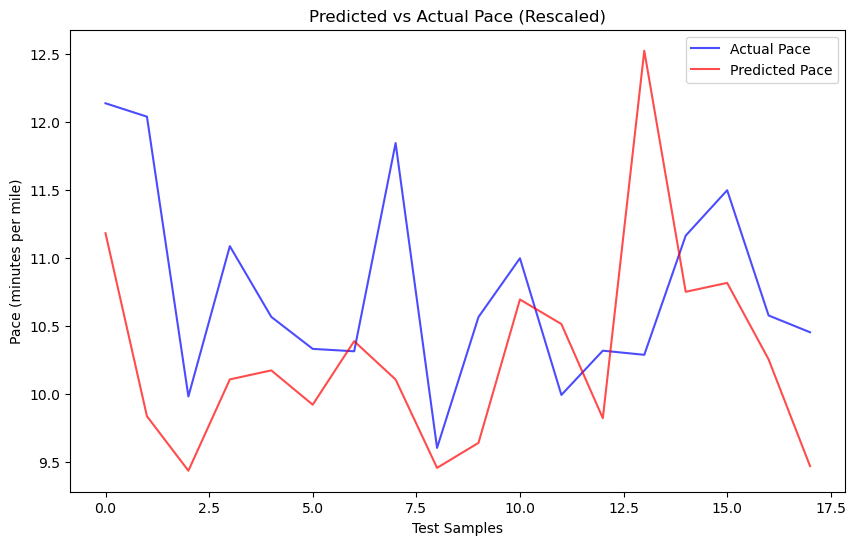

Root Mean Squared Error (RMSE): 1.0163


In [66]:
# Load the saved scaler
with open('/Users/eleanorbeers/Desktop/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Get predictions from the model
def get_predictions(model, X_test_tensor):
    with torch.no_grad():
        predictions = model(X_test_tensor)
    return predictions

# Get predictions on the test data
predictions = get_predictions(model, X_test_tensor).numpy()

# Create a placeholder for scaling - we just want the predicted pace values
scaled_data = np.zeros((len(predictions), 3))  
scaled_data[:, 1] = predictions.flatten() 

# Perform the inverse transformation
original_data = scaler.inverse_transform(scaled_data)
original_predictions = original_data[:, 1] 

# Rescale y_test to original scale
scaled_y_test = np.zeros((len(y_test), 3))
scaled_y_test[:, 1] = y_test.flatten()
original_y_test = scaler.inverse_transform(scaled_y_test)[:, 1]

# Visualize Rescaled Predicted vs Actual Pace
plt.figure(figsize=(10, 6))
plt.plot(original_y_test, label='Actual Pace', color='blue', alpha=0.7)
plt.plot(original_predictions, label='Predicted Pace', color='red', alpha=0.7)
plt.title('Predicted vs Actual Pace (Rescaled)')
plt.xlabel('Test Samples')
plt.ylabel('Pace (minutes per mile)')
plt.legend()
plt.show()

# Calculate RMSE on original scale
rmse = math.sqrt(mean_squared_error(original_y_test, original_predictions))
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


### Part 4: Use Model Predictions to Suggest Workout
Use model predictions to suggest next workout, ensuring that pace and mileage are realistic and workout type is accurate.

In [140]:
def suggest_next_day(model, last_week_data, start_date):
    """
    Suggest the next day's workout plan using the model's predictions, excluding elevation gain in the output.
    
    Args:
        model (torch.nn.Module): Trained PyTorch model for predicting features.
        last_week_data (np.ndarray): Data from the last week (shape: sequence_length x num_features).
        start_date (datetime): Starting date for the next workout.
    
    Returns:
        dict: Suggested workout plan for the next day.
    """
    assert last_week_data.shape[0] == 7, f"Invalid input shape: last_week_data must have 7 rows, got {last_week_data.shape[0]}"
    assert last_week_data.shape[1] == 5, f"Invalid input shape: last_week_data must have 5 features per row, got {last_week_data.shape[1]}"
    
    # Prepare the input tensor
    last_data_tensor = torch.tensor(last_week_data, dtype=torch.float32).unsqueeze(0)
    
    with torch.no_grad():
        predicted_scaled_pace = model(last_data_tensor).item() 
    
    # Create placeholder for inverse transformation - only want predicted pace
    last_distance, _, _, _, last_elevation_gain = last_week_data[-1]
    scaled_features = np.array([last_distance, predicted_scaled_pace, last_elevation_gain]).reshape(1, -1) 
    
    # Perform inverse transformation for all scaled features
    original_scaled_features = scaler.inverse_transform(scaled_features)  
    original_distance, original_pace, original_elevation_gain = original_scaled_features[0]

    # Cap distance and elevation_gain
    original_distance = min(max(original_distance, 1), 15)
    original_elevation_gain = min(max(original_elevation_gain, 0), 300)

    # Guide for workout type and pace adjustment (ensure pace is within realistic ranges)

    # Adjust pace dynamically by workout type
    if original_distance <= 3:
        workout_type = "Speed Work"
        pace = original_pace * 0.85  
    elif 3 < original_distance <= 8:
        workout_type = "Recovery Run"
        pace = original_pace * 1.1 
    else:  # original_distance > 8
        workout_type = "Long Run"
        pace = original_pace * 1.2  

    # Condense pace to realistic ranges
    if workout_type == "Speed Work":
        pace = min(max(pace, 6), 9) 
    elif workout_type == "Recovery Run":
        pace = min(max(pace, 9), 11)
    else:  # Long Run
        pace = min(max(pace, 10), 12)  

    next_day_plan = {
        "date": start_date.strftime('%Y-%m-%d'),
        "distance": round(original_distance, 2),
        "pace": pace,
    }

    return next_day_plan


### Part 5: Testing
Test workout suggestion function on simulated data.

In [141]:
# Test 1
# Simulated last week's data: Higher mileage, mixed distances
last_week_data = np.array([
    # miles, pace, time_of_day, day_of_week, elevation_gain
    [5.0, 9.5, 6, 0, 200],  
    [6.0, 9.8, 7, 1, 250],   
    [4.5, 10.0, 6, 2, 180], 
    [7.0, 9.2, 8, 3, 300],  
    [8.0, 9.0, 7, 4, 350],  
    [3.0, 10.5, 6, 5, 100], 
    [5.5, 9.9, 7, 6, 150],   
])

# Starting date for the next workout
start_date = datetime(2024, 12, 3)

# Generate the next day's workout plan
next_day_plan = suggest_next_day(model, last_week_data, start_date)

# Display the plan
print(next_day_plan)


Input tensor shape: torch.Size([1, 7, 5])
{'date': '2024-12-03', 'distance': 9.83, 'pace': 12}


In [142]:
# Test 2
# Simulated last week's data: Lower mileage, more rest-like
last_week_data = np.array([
    [3.0, 10.2, 7, 0, 150],  
    [2.5, 10.5, 6, 1, 120],  
    [3.5, 10.0, 8, 2, 180],   
    [4.0, 9.8, 7, 3, 200],    
    [2.0, 11.0, 6, 4, 100], 
    [1.5, 11.5, 7, 5, 80],    
    [2.5, 10.8, 6, 6, 90],    
])

# Starting date for the next workout
start_date = datetime(2024, 12, 3)

# Generate the next day's workout plan
next_day_plan = suggest_next_day(model, last_week_data, start_date)

# Display the plan
print(next_day_plan)


Input tensor shape: torch.Size([1, 7, 5])
{'date': '2024-12-03', 'distance': 6.2, 'pace': 11}


### Part 6: Build Gradio App

Use `suggest_next_day` function to generate a workout based on user input of previous week's runs (distance/pace).

In [165]:
# Gradio App

# Function to suggest the next day's workout plan
def suggest_next_day_gradio(last_week_data):
    """
    Wrapper for Gradio to suggest the next day's workout plan.
    
    Args:
        last_week_data (list): List of lists containing day, miles, and pace for the last 7 days.
    
    Returns:
        str: Suggested workout plan for the next day.
    """
    # Validate input
    try:
        formatted_data = np.array([[d[1], d[2], 7, i + 1, 150] for i, d in enumerate(last_week_data)], dtype=float)
    except ValueError:
        return "Invalid input: Please ensure all values for miles and pace are numbers."

    # Ensure 7 rows of data are provided
    if formatted_data.shape[0] != 7:
        return "Invalid input: Please provide exactly 7 rows of data for the last week."

    # Start date for the workout suggestion
    start_date = datetime.now() + timedelta(days=1)

    # Call the original function
    next_day_plan = suggest_next_day(model, formatted_data, start_date)

    # Format the output for display
    return f"Today's workout will be {next_day_plan['distance']} miles at {next_day_plan['pace']:.2f} min/mile. Happy running!"

# Gradio interface
def build_gradio_interface():
    # Define headers for the input table
    headers = ["Day", "Miles", "Pace"]

    # Static days of the week
    days_of_week = ["1", "2", "3", "4", "5", "6", "7 (Yesterday)"]
    initial_data = [[day, 0.0, 0.0] for day in days_of_week]

    # Gradio interface
    interface = gr.Interface(
        fn=suggest_next_day_gradio,
        inputs=gr.Dataframe(
            headers=headers,
            value=initial_data,
            datatype=["str", "number", "number"],
            row_count=7,
            col_count=3,
            type="array",
            label="Last Week's Training Data"
        ),
        outputs=gr.Textbox(label="Workout Plan"),
        title="Marathon Training Coach: Workout Suggestion",
        description="Input your last week's training data. Days of the week are static. Enter miles and pace for each day. Both must be valid numbers.",
        allow_flagging="never"
    )
    
    return interface

# Launch the Gradio app
app = build_gradio_interface()
app.launch()


Running on local URL:  http://127.0.0.1:7875

To create a public link, set `share=True` in `launch()`.


IMPORTANT: You are using gradio version 4.12.0, however version 4.44.1 is available, please upgrade.
--------
